# Tutorial


In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

## Instantaneous Pulses vs. Continous Drive

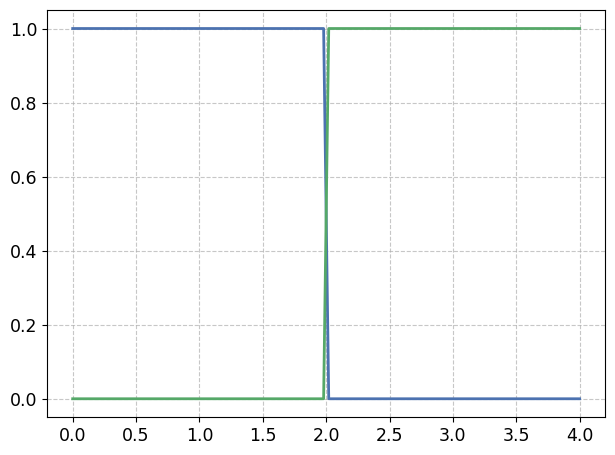

In [12]:
# instantaneous pulses
register_config = [ ('NV0', (0, 0, 0), 0, {}) ]

kwargs = dict(verbose = False)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ('free_evo', dict(t=2e-6)),
    ('inst_rot', dict(alpha=np.pi, phi=0)),
    ('free_evo', dict(t=2e-6)),
]

t_list= np.linspace(0, 4e-6, 100)
states = env.calc_states(t_list=t_list)[0, :]

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [state[0,0].real for state in states])
ax.plot(t_list*1e6, [state[1,1].real for state in states])
plt.show()

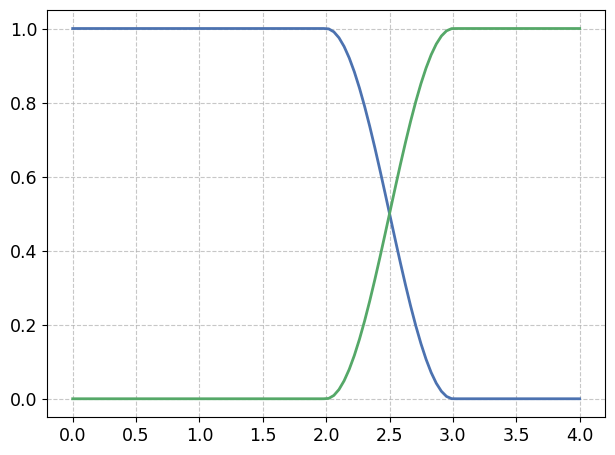

In [13]:
# continous drive (Rabi frequency 0.5 MHz, i.e., full rotation in 2 us)

# Note: use NV0 instead of NV for continous drive 
register_config = [('NV0', (0, 0, 0), 0, {})]

kwargs = dict(verbose = False)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ('free_evo', dict(t=2e-6)),
    ('cont_rot', dict(t=1e-6, phi=0)),
    ('free_evo', dict(t=2e-6)),
]

t_list= np.linspace(0, 4e-6, 100)
states = env.calc_states(t_list=t_list)[0, :]

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [state[0,0].real for state in states])
ax.plot(t_list*1e6, [state[1,1].real for state in states])
plt.show()

## Dynamical Decoupling and Hahn Echos

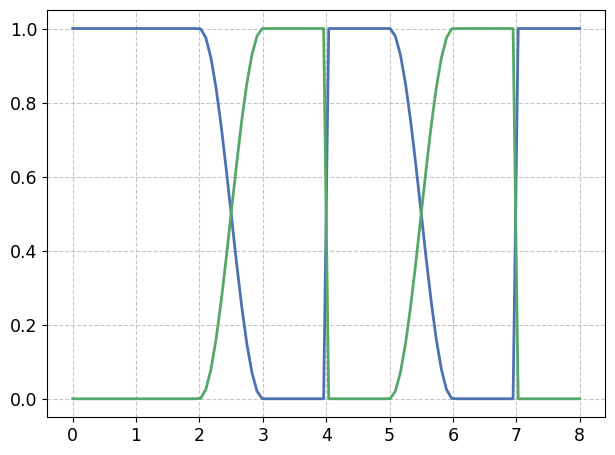

In [22]:
# dynamical decoupling

register_config = [('NV0', (0, 0, 0), 0, {})]

kwargs = dict(verbose = False)
env = Environment2(register_config, **kwargs)

env.dynamical_decoupling = True
env.gate_props_list = [
    ('free_evo', dict(t=2e-6, dynamical_decoupling=False)),
    ('cont_rot', dict(t=1e-6, phi=0)),
    ('free_evo', dict(t=2e-6, dyn_dec_time=1e-6)),    
    ('cont_rot', dict(t=1e-6, phi=0)),
    ('free_evo', dict(t=2e-6, dyn_dec_time=1e-6)),
]

t_list= np.linspace(0, 8e-6, 100)
states = env.calc_states(t_list=t_list)[0, :]

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [state[0,0].real for state in states])
ax.plot(t_list*1e6, [state[1,1].real for state in states])
plt.show()

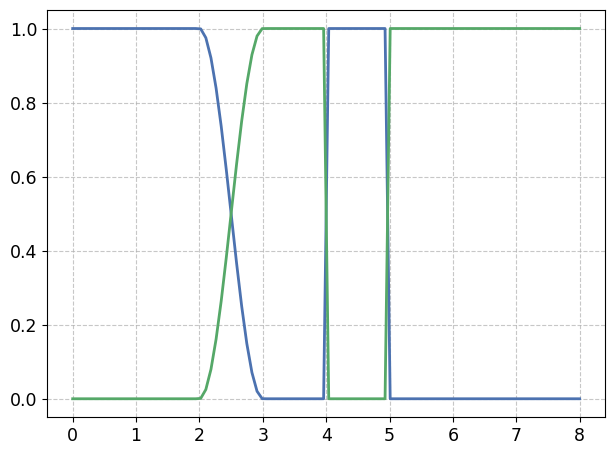

In [25]:
# Hahn echo (for even number nothing changes, for odd numbers the NV center is flipped because there is no inherent dynamics)
register_config = [('NV0', (0, 0, 0), 0, {})]

kwargs = dict(verbose = False)
env = Environment2(register_config, **kwargs)

env.dynamical_decoupling = True
env.num_hahn_echos = 1
env.gate_props_list = [
    ('free_evo', dict(t=2e-6, dynamical_decoupling=False)),
    ('cont_rot', dict(t=1e-6, phi=0)),
    ('free_evo', dict(t=2e-6, dyn_dec_time=1e-6)),
]

t_list= np.linspace(0, 8e-6, 100)
states = env.calc_states(t_list=t_list)[0, :]

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [state[0,0].real for state in states])
ax.plot(t_list*1e6, [state[1,1].real for state in states])
plt.show()

## Suter Method

In [27]:
init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

kwargs = dict(suter_method=True, verbose=False, target=bell_state, thermal_bath=False)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ("free_evo", dict(t=0.e-6)),
    ("inst_rot", dict(alpha=0.99813568, phi=0.69459264)),
    ("free_evo", dict(t=4.06620465e-6)),
    ("inst_rot", dict(alpha=3.57557112, phi=1.97327426)),
    ("free_evo", dict(t=1.57022726e-6)),
    ("inst_rot", dict(alpha=1.68300382, phi=0.50816523)),
    ("free_evo", dict(t=1.50788214e-6)),
]

env.get_values('fidelity')[0, 0]

array([0.99979934])

In [29]:
init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
C13_pos /= np.cbrt(np.pi*2) # 
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

kwargs = dict(suter_method=False, verbose=False, target=bell_state, thermal_bath=False)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ("free_evo", dict(t=0.e-6)),
    ("inst_rot", dict(alpha=0.99813568, phi=0.69459264)),
    ("free_evo", dict(t=4.06620465e-6)),
    ("inst_rot", dict(alpha=3.57557112, phi=1.97327426)),
    ("free_evo", dict(t=1.57022726e-6)),
    ("inst_rot", dict(alpha=1.68300382, phi=0.50816523)),
    ("free_evo", dict(t=1.50788214e-6)),
]

env.get_values('fidelity')[0, 0]

array([0.99979934])

## Thermal Bath

In [82]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.path.join(os.getcwd(), "baths")
filename = "dominik_bath_small"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

In [83]:
kwargs = dict(suter_method=True, verbose=False, target=bell_state, approx_level='full_bath', thermal_bath=True, bath_config=bath_configs[5])
env = Environment2(register_config, **kwargs)

env.system_init_states[0].diag()

array([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

In [84]:
kwargs = dict(suter_method=True, verbose=False, target=bell_state, approx_level='full_bath', thermal_bath=False, bath_config=bath_configs[5])
env = Environment2(register_config, **kwargs)

env.system_init_states[0].diag()

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Two Spin System

In [9]:
def plot_pops(env, t_list, states, ax):
    """Plot the populations of the spin states."""
    
    for i in range(env.register_num_spins):
        states_traced = [q.ptrace(state, [i]) for state in states]
        spin = env.register_spins[i]
        ax.plot(t_list*1e6, [q.expect(q.fock_dm(2,0), state) for state in states_traced], label=f"{spin.spin_type}_{0}")
        ax.plot(t_list*1e6, [q.expect(q.fock_dm(2,1), state) for state in states_traced], label=f"{spin.spin_type}_{1}")

    # plot settings
    ax.set_xlabel(r"Time [$\mu$s]")
    ax.set_title("Populations")
    ax.legend()
    return ax

def plot_obs(env, obs, t_list, states, ax):
    """Plot the expectation values of the spin operators."""

    for i in range(env.register_num_spins):
        states_traced = [q.ptrace(state, [i]) for state in states]
        spin = env.register_spins[i]

        for ob in obs:
            obs_keys = dict(X=q.sigmax(), Y=q.sigmay(), Z=q.sigmaz())
            ax.plot(t_list*1e6, [q.expect(obs_keys[ob], state) for state in states_traced], label=f"{spin.spin_type}_{ob}")
    # plot settings
    ax.set_xlabel(r"Time [$\mu$s]")
    ax.set_title("Observables")
    ax.legend()
    return ax

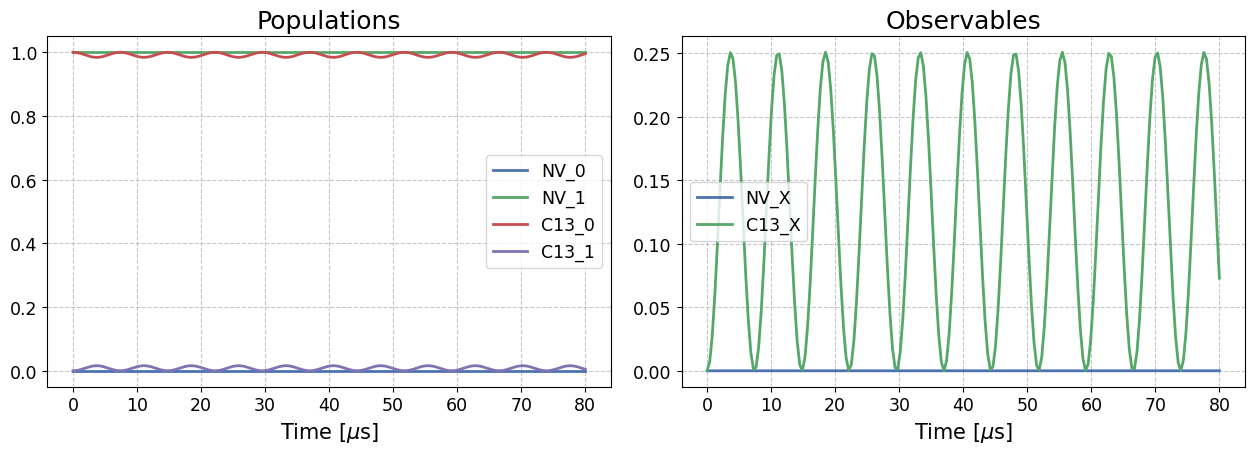

In [10]:
register_config = [('NV', (0,0,0), 1, {}), ('C13', C13_pos, 0, {})]
kwargs = dict(suter_method=False)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [('free_evo', dict(t=80e-6))]

t_list = np.linspace(0, 80e-6, 200)
states = env.calc_states(t_list=t_list)[0,:]

fig, ax = plt.subplots(1, 2, figsize = (6.4*2, 4.8))   
ax[0] = plot_pops(env, t_list, states, ax[0])
ax[1] = plot_obs(env, ['X'], t_list, states, ax[1])

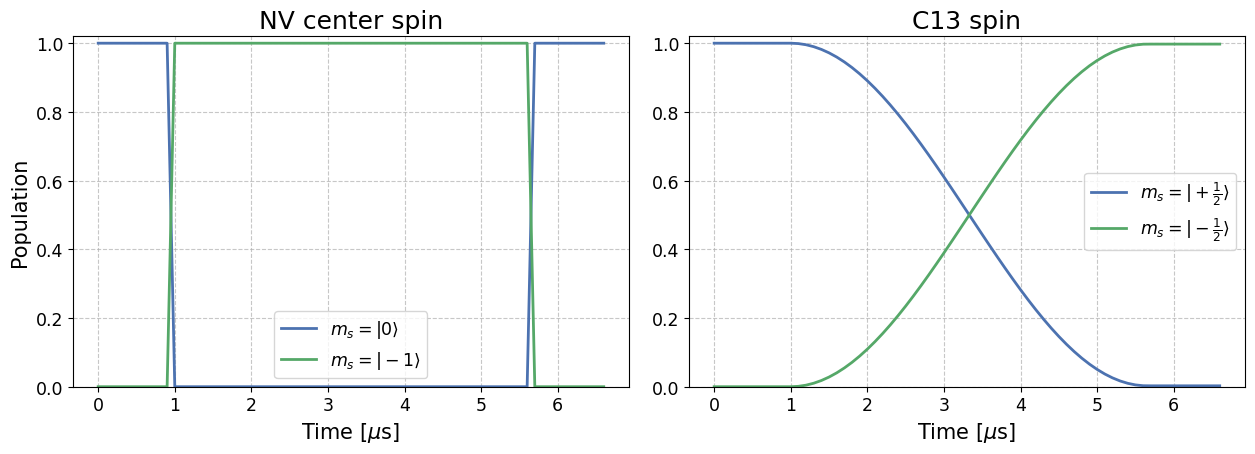

In [85]:
# pulse sequence to flip the C13 spin
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

kwargs = dict(suter_method=True, verbose=False)
env = Environment2(register_config, **kwargs)

matrix = env.calc_matrices()[0]
delta = matrix[2,3]
eps = matrix[3,3] - matrix[2,2]
T = np.pi/(2*np.pi*np.sqrt((delta**2 + eps**2)) ).real

env.gate_props_list = [
    ('free_evo', dict(t=1e-6)),
    ('inst_rot', dict(alpha=np.pi, phi=0)),
    ('free_evo', dict(t=T/2)),
    ('inst_rot', dict(alpha=np.pi, phi=0)),
    ('free_evo', dict(t=1e-6)),
]

t_list = np.arange(0, 2e-6+T/2, 0.1e-6)
states = env.calc_states(t_list=t_list)[0, :]

fig, ax = plot_pops(t_list, states)

## Reliablity of the Cluster Expansion

In [2]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.path.join(os.getcwd(), "baths")
filename = "dominik_bath_small"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

In [20]:
%%time
kwargs = dict(env_approx_level='gCCE2', instant_pulses=True, suter_method=True, verbose=False, target=bell_state, thermal_bath=False)
env = Environment(register_config, bath_configs, **kwargs)

t_list = np.linspace(env.total_time, 25e-6, 250)
pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]
log_negs_gCCE2 = env.get_values(pulse_seq, 'log_neg', t_list=t_list)

CPU times: total: 17.7 s
Wall time: 1min 48s


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# ax.plot(t_list*1e6, log_negs_no_bath, label='no bath')
# ax.plot(t_list*1e6, log_negs_gCCE0, label='gCCE0')
# ax.plot(t_list*1e6, log_negs_gCCE1, label='gCCE1')
ax.plot(t_list*1e6, log_negs_gCCE2, label='gCCE2')
# ax.plot(t_list*1e6, log_negs_full_bath, label='exact')
ax.legend()
ax.set_ylim(0,1.02)
plt.show()

In [22]:
%%time
kwargs = dict(env_approx_level='gCCE2', suter_method=True, verbose=False, target=bell_state, thermal_bath=False, bath_configs=bath_configs)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ("free_evo", dict(t=0.e-6)),
    ("inst_rot", dict(alpha=0.99813568, phi=0.69459264)),
    ("free_evo", dict(t=4.06620465e-6)),
    ("inst_rot", dict(alpha=3.57557112, phi=1.97327426)),
    ("free_evo", dict(t=1.57022726e-6)),
    ("inst_rot", dict(alpha=1.68300382, phi=0.50816523)),
    ("free_evo", dict(t=1.50788214e-6)),
]

t_list = np.linspace(env.total_gate_time, 25e-6, 250)
log_negs_gCCE2 = env.calc_values('log_neg', t_list=t_list)[0, :]

CPU times: total: 21.8 s
Wall time: 2min 2s


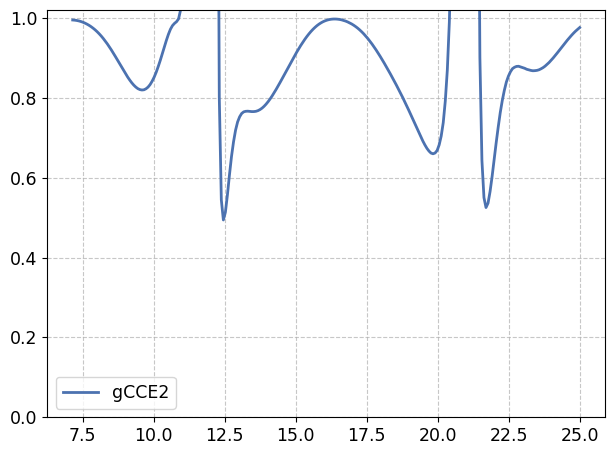

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# ax.plot(t_list*1e6, log_negs_no_bath, label='no bath')
# ax.plot(t_list*1e6, log_negs_gCCE0, label='gCCE0')
# ax.plot(t_list*1e6, log_negs_gCCE1, label='gCCE1')
ax.plot(t_list*1e6, log_negs_gCCE2, label='gCCE2')
# ax.plot(t_list*1e6, log_negs_full_bath, label='exact')
ax.legend()
ax.set_ylim(0,1.02)
plt.show()

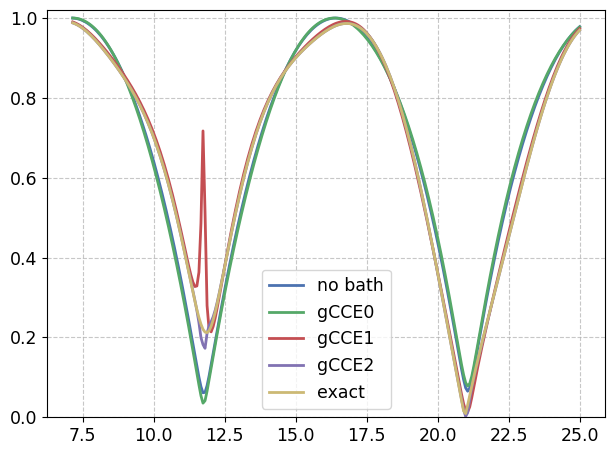

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(t_list*1e6, log_negs_no_bath, label='no bath')
ax.plot(t_list*1e6, log_negs_gCCE0, label='gCCE0')
ax.plot(t_list*1e6, log_negs_gCCE1, label='gCCE1')
ax.plot(t_list*1e6, log_negs_gCCE2, label='gCCE2')
ax.plot(t_list*1e6, log_negs_full_bath, label='exact')
ax.legend()
ax.set_ylim(0,1.02)
plt.show()